# Trabajo práctico de aprendizaje automático: clasificación automática de _Fake news_

- Nos propusimos procesar y etiquetar correctamente artículos de noticias, detectando aquellas que sean falsas.
- Para esto, utilizamos un dataset ya etiquetado que contiene ~18000 noticias falsas y ~21000 noticias verdaderas: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset.
- Decidimos restringirnos a clasificar los títulos de las noticias, para que sea más desafiante.

## 0. Importamos las bibliotecas a utilizar

In [1]:
# pip install --user sklearn
import sys
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
#! pip install --user pandas
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

## 1. Levantamos el dataset

In [2]:

fake = pd.read_csv("../archive/Fake.csv")
true = pd.read_csv("../archive/True.csv")

# ponemos los dos en uno
fake["label"] = 1
true["label"] = 0
df = pd.concat([fake, true], ignore_index = True)
print(df.title)

0         Donald Trump Sends Out Embarrassing New Year’...
1         Drunk Bragging Trump Staffer Started Russian ...
2         Sheriff David Clarke Becomes An Internet Joke...
3         Trump Is So Obsessed He Even Has Obama’s Name...
4         Pope Francis Just Called Out Donald Trump Dur...
                               ...                        
44893    'Fully committed' NATO backs new U.S. approach...
44894    LexisNexis withdrew two products from Chinese ...
44895    Minsk cultural hub becomes haven from authorities
44896    Vatican upbeat on possibility of Pope Francis ...
44897    Indonesia to buy $1.14 billion worth of Russia...
Name: title, Length: 44898, dtype: object


 ## 2. Preprocesamiento: limpiamos el texto

Transformamos el texto a minúscula, removemos signos de puntuación e interrogación, palabras con números, entre otras.

In [3]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    # agregar otras...
    return text

df.title = df.title.map(clean_text)
df.text = df.text.map(clean_text)

## 3. Vectorizamos el texto

Hicimos la experimentación utilizando dos vectorizadores de texto distintos:
- Count Vectorizer, que simplemente cuenta la cantidad de apariciones de cada palabra.
- Term Frequency Inverse Document Frequency, que incrementa proporcionalmente con la cantidad de apariciones de la palabra pero contrarresta con el número de documentos en el que está presente, permitiendo así que las palabras demasiado frecuentes y sin valor semántico no sean un problema.

In [4]:
USE_COUNT_VECTORIZER = False # Con este parametro controlamos cual vectorizador usar

In [5]:
# removemos palabras con muy alta o muy baja frecuencia. ademas, removemos las "stop words" del inglés
# (palabras como 'the', 'a', 'he', 'her', etc.)
def vectorize_text(dataframe):
    MAX_FREQ_THRESHOLD = 0.8
    MIN_FREQ_THRESHOLD = 0.003
    kwargs = {
        'stop_words': 'english',
        'max_df': MAX_FREQ_THRESHOLD,
        'min_df': MIN_FREQ_THRESHOLD
    }
    # DOCS: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    vect = CountVectorizer(**kwargs) if USE_COUNT_VECTORIZER else TfidfVectorizer(**kwargs)
    data_vectorized_titles = vect.fit_transform(dataframe.title)
    # print(cv.get_feature_names())  # vocabulario
    # print(len(cv.get_feature_names())) # tamaño del vocabulario
    data_dtm = pd.DataFrame(data_vectorized_titles.toarray(), columns=vect.get_feature_names())
    data_dtm.index = dataframe.index
    return data_dtm

data_dtm = vectorize_text(df)
data_dtm

/home/matias/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,act,action,ad,administration,admits,adviser,agency,ahead,aid,aide,...,wont,work,workers,working,world,wow,year,years,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541778,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
44894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
44895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
44896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## 4. Análisis exploratorio de datos

### 4.1 ¿Cuáles son las palabras más frecuentes en los títulos de cada tipo de noticia?

#### Palabras más frecuentes en las noticias falsas

In [6]:
data_fake = data_dtm[:len(fake)]
data_fake = data_fake.transpose()
data_fake_top = data_fake.sum(axis=1).sort_values(ascending=False)[:60]
fake_dict = list(zip(data_fake_top.index, map(round, data_fake_top.values)))
fake_dict[:10]

[('trump', 1749),
 ('video', 1147),
 ('watch', 735),
 ('hillary', 688),
 ('obama', 657),
 ('just', 567),
 ('trumps', 554),
 ('president', 436),
 ('clinton', 406),
 ('donald', 404)]

#### Palabras más frecuentes en las noticias verdaderas

In [7]:
data_true = data_dtm[len(fake):len(fake)+len(true)]
data_true = data_true.transpose()
data_true_top = data_true.sum(axis=1).sort_values(ascending=False)[:60]
true_dict = list(zip(data_true_top.index, map(round, data_true_top.values)))

"""
Borramos 'says', que no tiene valor semantico
"""
true_dict.pop(1) 
true_dict[:10]

[('trump', 1276),
 ('house', 562),
 ('north', 397),
 ('russia', 372),
 ('new', 370),
 ('korea', 351),
 ('senate', 345),
 ('white', 331),
 ('court', 326),
 ('china', 321)]

#### Y para visualizarlo un poco más lindo, usemos un WordCloud:

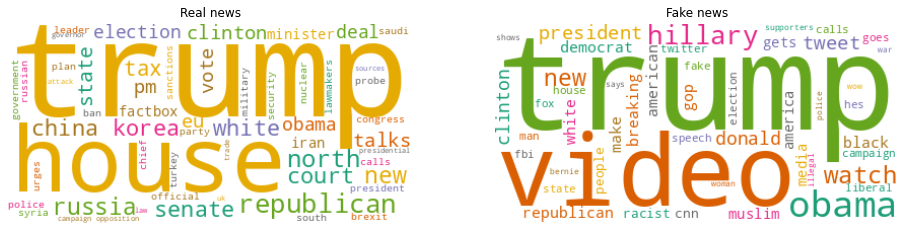

In [8]:
#!pip install WordCloud
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, collocations=False)

# Reset the output dimensions
import matplotlib.pyplot as plt

data_true_str = ''.join([(x[0] + ' ')*x[1] for x in true_dict])
data_fake_str = ''.join([(x[0] + ' ')*x[1] for x in fake_dict])
plt.rcParams['figure.figsize'] = [16, 6]
titles = ['Real news', 'Fake news']
data = [data_true_str, data_fake_str]
# Create subplots for each comedian
for index, data_str in enumerate(data):
    wc.generate(data[index])
    
    plt.subplot(1,2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titles[index])
    
plt.show()

- Las palabras que vemos tienen todas un buen valor semántico, indicando que el preprocesamiento del texto que hicimos es bueno. 
- Ambos tipos de noticias parecer tocar temas de política.
- Las noticias falsas parecen referenciar videos con alta frecuencia.

## 5. Downsample del dataset
Hacemos esto para que la experimentación dure menos, pero lo vamos a desactivar para reportar los resultados finales.

In [9]:
# Parametros de config
DO_DOWNSAMPLE = True
DOWNSAMPLING_SIZE=8000

if DO_DOWNSAMPLE:
    dtm_fake_downsampled = resample(data_fake.transpose(), n_samples=int(DOWNSAMPLING_SIZE/2), random_state=42)
    dtm_true_downsampled = resample(data_true.transpose(), n_samples=int(DOWNSAMPLING_SIZE/2), random_state=42)

dtm_downsampled = pd.concat([dtm_fake_downsampled, dtm_true_downsampled])
dtm_downsampled

,act,action,ad,administration,admits,adviser,agency,ahead,aid,aide,...,wont,work,workers,working,world,wow,year,years,york,young
15795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6. Partimos el dataset en un conjunto de training y otro de testing

In [10]:
if DO_DOWNSAMPLE:
    Y = np.array([1]*int(DOWNSAMPLING_SIZE/2) + [0]*int(DOWNSAMPLING_SIZE/2))
    X = dtm_downsampled.to_numpy()
else:
    Y = df['label'].to_numpy()
    X = data_dtm.to_numpy()
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

## 7. _Principal Component Analysis_ para reducir la dimensión de los datos

Pedimos que al menos el 90% de la varianza del input pueda ser explicada por los componentes principales.

In [11]:
VARIANCE_THRESHOLD = 0.90

#Si estamos usando el Count vectorizer debemos normalizar el texto. Notar que normalizamos el test sin saber su contenido

if (USE_COUNT_VECTORIZER):
    scaler = MinMaxScaler() #se puede poner el otro
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components = 0.90)
print('Pre PCA', len(X_train[0]))
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print('Post PCA', len(X_train[0]))

Pre PCA 495
Post PCA 366


## 8. Y la parte más jugosa: técnicas de NLP para clasificar las noticias

### 8.1: k-nearest neighbors
- Algoritmo simple de implementar y entender
- Lento para inputs grandes

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

#### 8.1.1: cross validation para hallar el mejor "k" de k-nearest neighbors 

In [13]:
param_grid = {'n_neighbors': np.arange(1, 30),
             'weights': ['uniform', 'distance'], # Indica si considerar la distancia en la prediccion
             'p': [1, 2] # 1 = Manhattan, 2 = Euclidea
             }
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=2)
knn_gscv.fit(X_train, Y_train)

best_accuracy = knn_gscv.best_score_
best_params = knn_gscv.best_params_
print("Best accuracy is", best_accuracy)
print("For parameters", best_params)


Fitting 5 folds for each of 116 candidates, totalling 580 fits
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.2s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   1.7s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   1.2s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=2, w

Accuracy para cada tupla de parametros


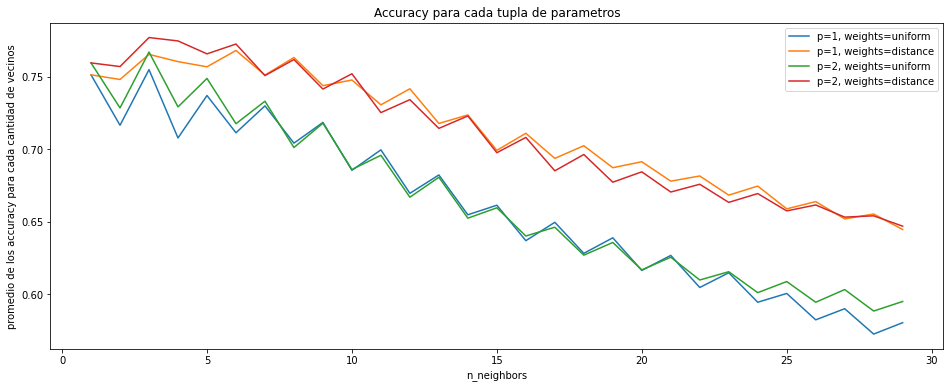

In [14]:
print('Accuracy para cada tupla de parametros')
list(zip(knn_gscv.cv_results_['params'], knn_gscv.cv_results_['mean_test_score']))

x1 = []
x2 = []
x3 = []
x4 = []
y1 = []
y2 = []
y3 = []
y4 = []


for i in range(0, len(knn_gscv.cv_results_['params'])):
    if(knn_gscv.cv_results_['params'][i]['p'] == 1 and knn_gscv.cv_results_['params'][i]['weights'] == 'uniform'):
        x1.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y1.append(knn_gscv.cv_results_['mean_test_score'][i])
    if(knn_gscv.cv_results_['params'][i]['p'] == 1 and knn_gscv.cv_results_['params'][i]['weights'] == 'distance'):
        x2.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y2.append(knn_gscv.cv_results_['mean_test_score'][i])
    if(knn_gscv.cv_results_['params'][i]['p'] == 2 and knn_gscv.cv_results_['params'][i]['weights'] == 'uniform'):
        x3.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y3.append(knn_gscv.cv_results_['mean_test_score'][i])
    if(knn_gscv.cv_results_['params'][i]['p'] == 2 and knn_gscv.cv_results_['params'][i]['weights'] == 'distance'):
        x4.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y4.append(knn_gscv.cv_results_['mean_test_score'][i])
    

fig, ax = plt.subplots()
ax.plot(x1, y1, label="p=1, weights=uniform")
ax.plot(x2, y2, label="p=1, weights=distance")
ax.plot(x3, y3, label="p=2, weights=uniform")
ax.plot(x4, y4, label="p=2, weights=distance")
ax.set_xlabel('n_neighbors')
ax.set_ylabel('promedio de los accuracy para cada cantidad de vecinos')
ax.legend()
plt.title('Accuracy para cada tupla de parametros')
plt.show()

#### 8.1.2: score obtenido para k-nearest neighbors

In [15]:
tuned_knn = KNeighborsClassifier(**best_params)
tuned_knn.fit(X_train, Y_train)
score_knn = tuned_knn.score(X_test, Y_test)
score_knn

0.7891666666666667

### 8.2: Support Vector Machines
- Intuitivamente, lo que hace es separar los datos mediante un hiperplano.
- En general, reduce la cantidad de etiquetas necesarias para alcanzar una buena clasificación, en comparación a otros métodos.
- Require un _workaround_ si hay variables categóricas (e.g. 'ESTADO CIVIL' puede ser soltero, casado, divorciado, etc.). No es el caso de este trabajo.

In [16]:
svm_classifier = svm.SVC(max_iter=5000)

#### 8.2.2: cross validation para hallar los mejores hiperparámetros de la Support Vector Machine

In [17]:
param_grid = [
    {'C': [1], # poner [0.5, 1, 10, 100] para exp final
    'gamma': ['scale'], # poner ['scale', 1, 0.1, 0.01, 0.001, 0.0001] para exp final
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
]
#Default values are C=1 and gamma='scale'
svm_gscv = GridSearchCV(
    svm_classifier,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2
)
svm_gscv.fit(X_train, Y_train)

best_accuracy = svm_gscv.best_score_
best_params = svm_gscv.best_params_
print("Best accuracy is", best_accuracy)
print("For parameters", best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   2.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   2.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   2.4s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   2.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   3.2s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.7s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.5s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.7s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.9s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   3.2s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   3.0s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   2.7s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   2.7s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   2.7s


/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.8s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.8s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.9s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.8s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.9s
Best accuracy is 0.8619642857142857
For parameters {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


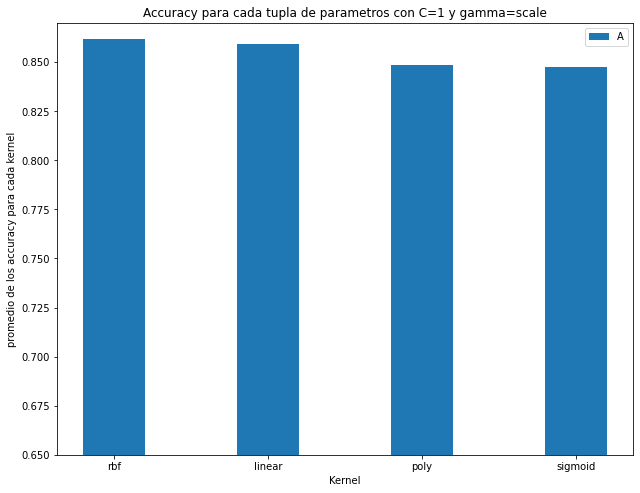

[0.86196429 0.85910714 0.84857143 0.84767857]


In [18]:
#print('Accuracy para cada tupla de parametros')
#print(list(zip(svm_gscv.cv_results_['params'], svm_gscv.cv_results_['mean_test_score'])))

x = []
y = svm_gscv.cv_results_['mean_test_score']


for i in range(0, len(svm_gscv.cv_results_['params'])):
    x.append(svm_gscv.cv_results_['params'][i]['kernel'])


fig = plt.figure()
ax = fig.add_axes([0,0,0.5,1])
ax.bar(x,y, width=0.4)
ax.set_ylim(0.65,0.87)
ax.set_xlabel('Kernel')
ax.set_ylabel('promedio de los accuracy para cada kernel')
ax.legend('Accuracy')
plt.title('Accuracy para cada tupla de parametros con C=1 y gamma=scale')
plt.show()
print(y)


#### 8.2.2: score obtenido para nuestra Support Vector Machine

In [19]:
tuned_svm = svm.SVC(**best_params)
tuned_svm.fit(X_train, Y_train)
score_svm = tuned_svm.score(X_test, Y_test)
score_svm

0.8758333333333334

Podemos comprobar que utilizando la misma cantidad de muestras, obtuvimos un aumento en la precisión de alrededor de 7 puntos en comparación a Knn, ya que pasamos de 79% a 85% de accuracy.

### 8.3: Regresión Logística
- Método utilizado para predecir el valor de una variable categórica (en nuestro caso, 'Fake' o 'Real') a partir de muchas variables predictoras (las palabras de las noticias)

In [20]:
lr_classifier = LogisticRegression()

#### 8.3.2: cross validation para hallar los mejores hiperparámetros de Regresión Logística

In [21]:
param_grid = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear']
    }

lr_gscv = GridSearchCV(
    lr_classifier,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2
)
lr_gscv.fit(X_train, Y_train)

best_accuracy = lr_gscv.best_score_
best_params = lr_gscv.best_params_
print("Best accuracy is", best_accuracy)
print("For parameters", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.000774263682681127, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.000774263682681127, penalty=l1, s

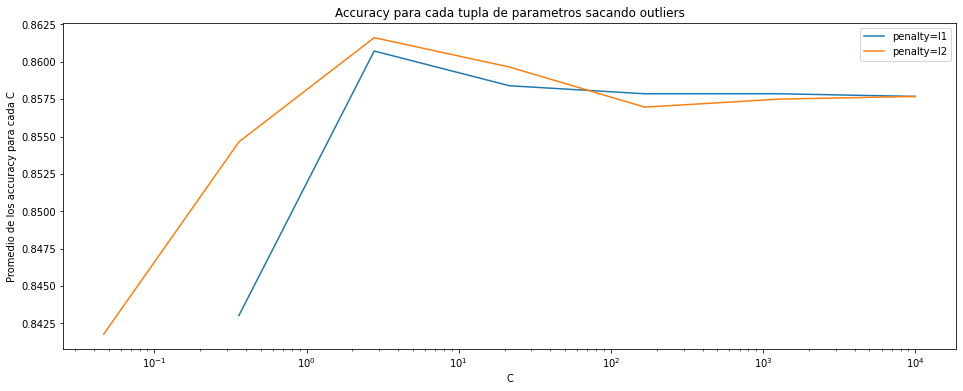

In [27]:
#print('Accuracy para cada tupla de parametros')
#list(zip(lr_gscv.cv_results_['params'], lr_gscv.cv_results_['mean_test_score']))
x1 = []
x2 = []
y1 = []
y2 = []


for i in range(0, len(lr_gscv.cv_results_['params'])):
    if(lr_gscv.cv_results_['params'][i]['penalty'] == 'l1'):
        if(lr_gscv.cv_results_['mean_test_score'][i]> 0.84):
            x1.append(lr_gscv.cv_results_['params'][i]['C'])
            y1.append(lr_gscv.cv_results_['mean_test_score'][i])
    if(lr_gscv.cv_results_['params'][i]['penalty'] == 'l2'):
        if(lr_gscv.cv_results_['mean_test_score'][i]> 0.84):
            x2.append(lr_gscv.cv_results_['params'][i]['C'])
            y2.append(lr_gscv.cv_results_['mean_test_score'][i])
    

fig, ax = plt.subplots()
ax.plot(x1, y1, label="penalty=l1")
ax.plot(x2, y2, label="penalty=l2")
ax.set_xlabel('C')
ax.set_xscale('log')
ax.set_ylabel('Promedio de los accuracy para cada C')
ax.legend()
plt.title('Accuracy para cada tupla de parametros sacando outliers')
plt.show()

#### 8.3.3: score obtenido para la Regresión Logística

In [23]:
lr = LogisticRegression(**best_params)
lr.fit(X_train,Y_train)
score_lr = lr.score(X_test, Y_test)
score_lr

0.8704166666666666

### 8.4: Red Neuronal
- Construimos nuestra propia red neuronal.
- Fuimos explorando variando los siguientes hiperparámetros de la red: cantidad de nodos y capas, función de activacion, inicializador y vectorizador.

In [24]:
%run ANN.ipynb

epoch = 5
learning_rate = 0.005

network = [
  fullyConnectedLayer(X_train.shape[1], 64,'xavier'),
  activationLayer(relu, relu_prime),
  fullyConnectedLayer(64, 32,'xavier'),
  activationLayer(relu, relu_prime),
  fullyConnectedLayer(32, 16,'xavier'),
  activationLayer(relu, relu_prime),
  fullyConnectedLayer(16, 1,'xavier'),
  activationLayer(sigmoid, sigmoid_prime),

  ]
X_train_reshaped=X_train.reshape((5600, 1,X_train.shape[1]))
compile_(network,epoch,learning_rate,X_train_reshaped,Y_train)
score_nn = sum([y == np.round(predict(network, x)[0][0]) for x, y in zip(X_test, Y_test)]) / len(X_test)
error = sum([mse(y, predict(network, x)) for x, y in zip(X_test, Y_test)]) / len(X_test)
print('ratio: %.2f' % score_nn)


1/5, error=0.245381
2/5, error=0.217789
3/5, error=0.145728
4/5, error=0.109242
5/5, error=0.097724
ratio: 0.86


## Análisis final y conclusión

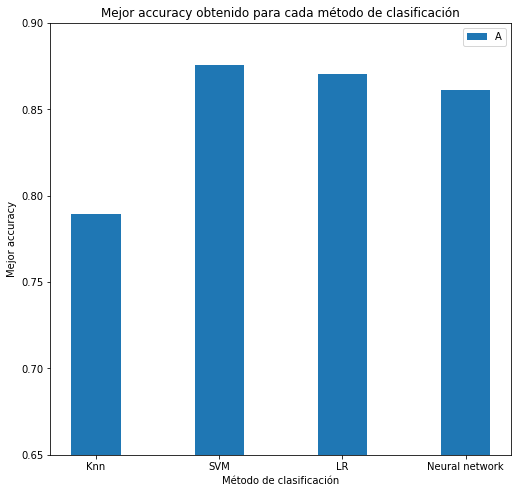

[0.7891666666666667, 0.8758333333333334, 0.8704166666666666, 0.8608333333333333]


In [25]:
x = ['Knn', 'SVM', 'LR', 'Neural network']
y = [score_knn, score_svm, score_lr, score_nn]

fig = plt.figure()
ax = fig.add_axes([0,0,0.4,1])
ax.bar(x,y, width=0.4)
ax.set_xlabel('Método de clasificación')
ax.set_ylabel('Mejor accuracy')
ax.set_ylim(0.65,0.9)
ax.legend('Accuracy')
plt.title('Mejor accuracy obtenido para cada método de clasificación')
plt.show()
print(y)

- Alcanzamos niveles de precisión altos con todos los clasificadores, pero en particular mayor con aquellos que tienen un nivel de complejidad alto (Support Vector Machines y Logistic Regression), que demostraron funcionar muy bien con un dataset reducido (más de 85% de precisión con el downsample hecho).
- El preprocesamiento de los datos resultó ser bueno, ya que al visualizar las palabras más frecuentes pudimos ver que no aparecen palabras como 'the', 'a', 'many', 'he', etc., que no aportan valor semántico y no contribuyen a lograr buenos resultados en la clasificación.
- La optimización de hiperparámetros consumió mucho tiempo para ser computados pero ayudó a mejorar los resultados.